In [1]:
# Cell 1 - Environment Setup
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
# Cell 2 - Install Required Packages
!pip install -q transformers datasets scikit-learn torch torchvision torchaudio
!pip install -q accelerate  # For better GPU utilization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Cell 3 - Import Libraries and Setup
import os
import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_cosine_schedule_with_warmup
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# Reproducibility - Enhanced seed setting
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Device: cuda
CUDA available: True
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.9 GB


In [4]:
# Cell 4 - Optimized Model Configuration
# DeBERTa-v3 Configuration - Overfitting Resistant
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS_INITIAL = 2    
TOTAL_EPOCHS = 4  # Reduced to prevent overfitting
LR = 8e-6  # Lower learning rate for DeBERTa
OUTPUT_DIR = "/kaggle/working/sentiment140_deberta_v3"
CHECKPOINT_PATH = os.path.join(OUTPUT_DIR, "checkpoint.pt")
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, "best_model.pt")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Enhanced configuration
CONFIG = {
    'model_name': MODEL_NAME,
    'max_length': MAX_LEN,
    'batch_size': BATCH_SIZE,
    'learning_rate': LR,
    'weight_decay': 0.02,  # Increased regularization
    'warmup_ratio': 0.15,  # Extended warmup
    'epochs': TOTAL_EPOCHS,
    'patience': 1,  # Aggressive early stopping
    'gradient_accumulation_steps': 2,
    'max_grad_norm': 0.5,  # Reduced gradient clipping
    'dropout_rate': 0.4,  # Increased dropout
    'label_smoothing': 0.1,
    'output_dir': OUTPUT_DIR
}

use_amp = torch.cuda.is_available()
print("Configuration loaded!")
print(f"AMP enabled: {use_amp}")
print(f"Model: {MODEL_NAME}")
print(f"Max Length: {MAX_LEN}, Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LR}, Total Epochs: {TOTAL_EPOCHS}")

Configuration loaded!
AMP enabled: True
Model: microsoft/deberta-v3-base
Max Length: 128, Batch Size: 32
Learning Rate: 8e-06, Total Epochs: 4


In [5]:
# Cell 5 - Load and Initial Data Processing
print("Loading Sentiment140 dataset...")

# Load dataset
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding='latin-1', 
                 header=None, 
                 names=['sentiment','id','date','query','user','text'])

# Basic preprocessing
df = df[['text', 'sentiment']].copy()
df['label'] = df['sentiment'].map({0: 0, 4: 1})  # 0: negative, 1: positive
df = df[['text', 'label']].dropna()

print(f"Dataset loaded: {len(df):,} samples")
print(f"Label distribution:")
print(df['label'].value_counts())
print(f"\nSample data:")
print(df.head())

# Memory cleanup
#del df['sentiment'] if 'sentiment' in df.columns else None

Loading Sentiment140 dataset...
Dataset loaded: 1,600,000 samples
Label distribution:
label
0    800000
1    800000
Name: count, dtype: int64

Sample data:
                                                text  label
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      0
1  is upset that he can't update his Facebook by ...      0
2  @Kenichan I dived many times for the ball. Man...      0
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      0


In [6]:
# Cell 6 - Conservative Text Cleaning
def clean_tweet_conservative(text):
    """
    Conservative text cleaning - prevents overfitting to specific patterns
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    
    # Minimal cleaning to preserve natural language patterns
    text = re.sub(r"http\S+|www\S+", " ", text)  # Remove URLs
    text = re.sub(r"@\w+", " ", text)           # Remove mentions
    text = re.sub(r"#(\w+)", r"\1", text)       # Remove # but keep hashtag text
    
    # Keep important punctuation for sentiment
    text = re.sub(r"[^\w\s\.\!\?\,\:\;\-\'\"]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Preserve case - let model learn case sensitivity
    return text

print("Applying conservative text cleaning...")
df['text'] = df['text'].apply(clean_tweet_conservative)

# Remove very short texts that might cause issues
df = df[df['text'].str.len() > 5].reset_index(drop=True)
print(f"After cleaning: {len(df):,} samples")

# Show cleaning examples
print("\nCleaning examples:")
sample_indices = [0, 1000, 5000]
for i in sample_indices:
    if i < len(df):
        print(f"Sample {i}: {df.iloc[i]['text'][:100]}...")

Applying conservative text cleaning...
After cleaning: 1,592,444 samples

Cleaning examples:
Sample 0: - A that's a bummer. You shoulda got David Carr of Third Day to do it. ;D...
Sample 1000: i'm sitting at my house and i'm sooo not looking forward to my one class tomorrow....
Sample 5000: Poor you. I just finished work. You'll get through the day....


In [7]:
# Cell 7 - FIXED: Data Splitting with Duplicate Removal and Leakage Prevention
def remove_duplicates_and_split(df, test_size=0.2, val_size=0.1, random_state=SEED):
    """
    Remove duplicates and create safe data splits without leakage
    """
    print("Original dataset size:", len(df))
    
    # 1. Remove duplicate texts first
    print("Removing duplicate texts...")
    df_clean = df.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)
    print(f"After removing duplicates: {len(df_clean)} samples ({len(df) - len(df_clean)} duplicates removed)")
    
    # 2. Create unique text groups for splitting
    unique_texts = df_clean['text'].unique()
    print(f"Unique texts: {len(unique_texts)}")
    
    # 3. Create a mapping of text to labels (in case of conflicts, take majority)
    text_to_label = {}
    for _, row in df_clean.iterrows():
        text = row['text']
        label = row['label']
        if text in text_to_label:
            # If duplicate text with different label, keep the first one
            continue
        text_to_label[text] = label
    
    # 4. Create final clean dataset
    final_texts = list(text_to_label.keys())
    final_labels = list(text_to_label.values())
    
    clean_df = pd.DataFrame({
        'text': final_texts,
        'label': final_labels
    })
    
    print(f"Final clean dataset: {len(clean_df)} samples")
    print(f"Label distribution after cleaning:")
    print(clean_df['label'].value_counts(normalize=True))
    
    # 5. Split the clean data
    # First split: train+val vs test
    train_val_df, test_df = train_test_split(
        clean_df, 
        test_size=test_size, 
        stratify=clean_df['label'], 
        random_state=random_state,
        shuffle=True
    )
    
    # Second split: train vs val
    val_size_adjusted = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=val_size_adjusted, 
        stratify=train_val_df['label'], 
        random_state=random_state,
        shuffle=True
    )
    
    return train_df, val_df, test_df

def comprehensive_leakage_check(train_df, val_df, test_df):
    """
    Comprehensive data leakage check
    """
    print("\n🔍 COMPREHENSIVE DATA LEAKAGE CHECK")
    print("="*50)
    
    # Convert to sets for faster intersection
    train_texts = set(train_df['text'].values)
    val_texts = set(val_df['text'].values)
    test_texts = set(test_df['text'].values)
    
    # Check overlaps
    train_val_overlap = train_texts.intersection(val_texts)
    train_test_overlap = train_texts.intersection(test_texts)
    val_test_overlap = val_texts.intersection(test_texts)
    
    print(f"Train-Val overlap: {len(train_val_overlap)}")
    print(f"Train-Test overlap: {len(train_test_overlap)}")
    print(f"Val-Test overlap: {len(val_test_overlap)}")
    
    # Check for any overlap
    total_overlap = len(train_val_overlap) + len(train_test_overlap) + len(val_test_overlap)
    
    if total_overlap == 0:
        print("✅ NO DATA LEAKAGE DETECTED!")
        return True
    else:
        print("❌ DATA LEAKAGE DETECTED!")
        
        # Show examples of overlapping texts
        if train_val_overlap:
            print(f"\nExample Train-Val overlaps:")
            for i, text in enumerate(list(train_val_overlap)[:3]):
                print(f"  {i+1}. {text[:100]}...")
        
        if train_test_overlap:
            print(f"\nExample Train-Test overlaps:")
            for i, text in enumerate(list(train_test_overlap)[:3]):
                print(f"  {i+1}. {text[:100]}...")
                
        return False

def validate_splits_statistics(train_df, val_df, test_df):
    """
    Validate split statistics and distributions
    """
    print(f"\n📊 SPLIT STATISTICS VALIDATION")
    print("="*50)
    
    total_samples = len(train_df) + len(val_df) + len(test_df)
    
    print(f"Dataset sizes:")
    print(f"  Train: {len(train_df):,} ({len(train_df)/total_samples*100:.1f}%)")
    print(f"  Val  : {len(val_df):,} ({len(val_df)/total_samples*100:.1f}%)")
    print(f"  Test : {len(test_df):,} ({len(test_df)/total_samples*100:.1f}%)")
    print(f"  Total: {total_samples:,}")
    
    print(f"\nLabel distributions:")
    for name, data in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        dist = data['label'].value_counts(normalize=True)
        print(f"  {name:5}: Neg={dist[0]:.3f}, Pos={dist[1]:.3f}")
    
    # Check if distributions are similar (should be close to 0.5/0.5)
    distributions_ok = True
    for name, data in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        dist = data['label'].value_counts(normalize=True)
        if abs(dist[0] - 0.5) > 0.05 or abs(dist[1] - 0.5) > 0.05:  # More than 5% deviation
            print(f"⚠️ Warning: {name} distribution seems imbalanced")
            distributions_ok = False
    
    if distributions_ok:
        print("✅ All distributions look balanced!")
    
    return distributions_ok

# Execute the improved data splitting
print("🔄 FIXING DATA LEAKAGE ISSUE...")
print("="*60)

# Remove duplicates and create safe splits
train_df, val_df, test_df = remove_duplicates_and_split(df)

# Comprehensive validation
leakage_free = comprehensive_leakage_check(train_df, val_df, test_df)
distributions_ok = validate_splits_statistics(train_df, val_df, test_df)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

if leakage_free and distributions_ok:
    print(f"\n🎉 DATA SPLITTING SUCCESSFUL!")
    print(f"✅ No data leakage")
    print(f"✅ Balanced distributions")
    print(f"✅ Ready for training")
else:
    print(f"\n⚠️ ISSUES DETECTED - PLEASE REVIEW")

print(f"\n📋 FINAL DATASET SUMMARY:")
print(f"Train: {len(train_df):,} samples")
print(f"Val  : {len(val_df):,} samples") 
print(f"Test : {len(test_df):,} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

🔄 FIXING DATA LEAKAGE ISSUE...
Original dataset size: 1592444
Removing duplicate texts...
After removing duplicates: 1547561 samples (44883 duplicates removed)
Unique texts: 1547561
Final clean dataset: 1547561 samples
Label distribution after cleaning:
label
0    0.503245
1    0.496755
Name: proportion, dtype: float64

🔍 COMPREHENSIVE DATA LEAKAGE CHECK
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0
✅ NO DATA LEAKAGE DETECTED!

📊 SPLIT STATISTICS VALIDATION
Dataset sizes:
  Train: 1,083,292 (70.0%)
  Val  : 154,756 (10.0%)
  Test : 309,513 (20.0%)
  Total: 1,547,561

Label distributions:
  Train: Neg=0.503, Pos=0.497
  Val  : Neg=0.503, Pos=0.497
  Test : Neg=0.503, Pos=0.497
✅ All distributions look balanced!

🎉 DATA SPLITTING SUCCESSFUL!
✅ No data leakage
✅ Balanced distributions
✅ Ready for training

📋 FINAL DATASET SUMMARY:
Train: 1,083,292 samples
Val  : 154,756 samples
Test : 309,513 samples
Total: 1,547,561 samples


In [8]:
# Cell 8 - Tokenizer and Dataset Creation (memory-friendly)
# Load DeBERTa-v3 tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")

# We switch to on-the-fly tokenization to avoid storing all encodings in RAM/VRAM.
from transformers import DataCollatorWithPadding

class LazyTextDataset(Dataset):
    """Dataset that returns raw text and label; tokenization happens in collate_fn."""
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {"text": self.texts[idx], "labels": self.labels[idx]}

# Data collator will dynamically pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest", return_tensors="pt")

def collate_fn(batch):
    # Batch tokenization (on-the-fly) + dynamic padding
    texts = [b["text"] for b in batch]
    labels = torch.stack([b["labels"] for b in batch])
    enc = tokenizer(texts, truncation=True, max_length=MAX_LEN, padding=False, return_attention_mask=True)
    # Convert lists to tensors and prepare features for the data_collator
    features = [
        {"input_ids": torch.tensor(ids, dtype=torch.long), "attention_mask": torch.tensor(mask, dtype=torch.long)}
        for ids, mask in zip(enc['input_ids'], enc['attention_mask'])
    ]
    batch_enc = data_collator(features)
    batch_enc['labels'] = labels
    return batch_enc

# Create lazy datasets (no pre-tokenization)
train_dataset = LazyTextDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = LazyTextDataset(val_df["text"].tolist(), val_df["label"].tolist())
test_dataset = LazyTextDataset(test_df["text"].tolist(), test_df["label"].tolist())

# NOTE: If you hit OOM, reduce BATCH_SIZE (e.g., 8 or 16) and/or set num_workers=0 and pin_memory=False.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=False)

print("On-the-fly tokenization DataLoaders created (no pre-tokenized encodings).")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Tokenizer loaded: microsoft/deberta-v3-base


2025-10-29 07:34:20.873722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761723261.066789      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761723261.119038      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


On-the-fly tokenization DataLoaders created (no pre-tokenized encodings).
  Train batches: 33852
  Val batches: 2419
  Test batches: 4837


In [9]:
# Cell 9 - DataLoader summary (pre-tokenization removed)
# Previous pre-tokenization approach was removed and replaced by on-the-fly tokenization in Cell 8.
print("✅ DataLoader setup updated: using on-the-fly tokenization and dynamic padding.")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

# Quick sanity: fetch a single batch to check shapes (won't move model/data to GPU).
batch = next(iter(train_loader))
print("Sample batch keys:", list(batch.keys()))
print("input_ids shape:", batch['input_ids'].shape)
print("attention_mask shape:", batch['attention_mask'].shape)
print("labels shape:", batch['labels'].shape)

# If you hit CUDA OOM during training, lower BATCH_SIZE in Cell 4 (e.g., 8 or 16) and set num_workers=0.

✅ DataLoader setup updated: using on-the-fly tokenization and dynamic padding.
Train batches: 33852 | Val batches: 2419 | Test batches: 4837
Sample batch keys: ['input_ids', 'attention_mask', 'labels']
input_ids shape: torch.Size([32, 38])
attention_mask shape: torch.Size([32, 38])
labels shape: torch.Size([32])


In [10]:
# Cell 10 - Model Initialization with Enhanced Regularization (FIXED)
print("Loading DeBERTa-v3 model...")

# Load model with correct dropout configuration for DeBERTa-v3
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=2,
    hidden_dropout_prob=CONFIG['dropout_rate'],      # 0.4
    attention_probs_dropout_prob=CONFIG['dropout_rate'],  # 0.4
    # classifier_dropout=0.5,  # ❌ DeBERTa-v3'te desteklenmiyor
    layer_norm_eps=1e-7
).to(device)

# Manuel classifier dropout ekleme (daha iyi kontrol)
if hasattr(model, 'classifier') and hasattr(model.classifier, 'dropout'):
    model.classifier.dropout.p = 0.5  # Manuel dropout ayarı
    print("✅ Classifier dropout manually set to 0.5")
elif hasattr(model, 'classifier'):
    # Eğer dropout layer yoksa ekle
    import torch.nn as nn
    original_classifier = model.classifier
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        original_classifier
    )
    print("✅ Dropout layer added before classifier")

# Model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model loaded successfully!")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024**2:.1f} MB")

# Model architecture kontrolü
print(f"  Model type: {type(model).__name__}")
print(f"  Hidden dropout: {model.config.hidden_dropout_prob}")
print(f"  Attention dropout: {model.config.attention_probs_dropout_prob}")

# Classifier architecture'ı göster
print(f"  Classifier: {model.classifier}")

Loading DeBERTa-v3 model...


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Dropout layer added before classifier
Model loaded successfully!
  Total parameters: 184,423,682
  Trainable parameters: 184,423,682
  Model size: ~703.5 MB
  Model type: DebertaV2ForSequenceClassification
  Hidden dropout: 0.4
  Attention dropout: 0.4
  Classifier: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=768, out_features=2, bias=True)
)


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [11]:
# Cell 11 - Optimizer and Scheduler Setup
# Enhanced optimizer with weight decay
no_decay = ['bias', 'LayerNorm.weight', 'layer_norm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': CONFIG['weight_decay'],  # 0.02
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0,
    }
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=CONFIG['learning_rate'],  # 8e-6
    eps=1e-8,
    betas=(0.9, 0.999)
)

# Cosine scheduler with warmup (better than linear for DeBERTa)
total_steps = len(train_loader) * CONFIG['epochs'] // CONFIG['gradient_accumulation_steps']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])  # 15% warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print("Optimizer and scheduler configured!")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Weight decay: {CONFIG['weight_decay']}")
print(f"  Total steps: {total_steps}")
print(f"  Warmup steps: {warmup_steps}")
print(f"  Warmup ratio: {CONFIG['warmup_ratio']}")

Optimizer and scheduler configured!
  Learning rate: 8e-06
  Weight decay: 0.02
  Total steps: 67704
  Warmup steps: 10155
  Warmup ratio: 0.15


In [20]:
# Cell 12 - Checkpoint Management Functions
def save_checkpoint(path, model, optimizer, scheduler, epoch, val_acc, val_loss):
    """Save training checkpoint"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_acc': val_acc,
        'val_loss': val_loss,
        'config': CONFIG
    }, path)
    print(f"Checkpoint saved -> {path}")

def load_checkpoint(path, model, optimizer=None, scheduler=None, device=device):
    """Load training checkpoint"""
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Checkpoint not found: {path}")
    
    ckpt = torch.load(path, map_location=device, weights_only=False)

    model.load_state_dict(ckpt['model_state_dict'])
    
    if optimizer and 'optimizer_state_dict' in ckpt:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler and 'scheduler_state_dict' in ckpt:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    
    start_epoch = ckpt.get('epoch', 0)
    val_acc = ckpt.get('val_acc', 0)
    val_loss = ckpt.get('val_loss', float('inf'))
    
    print(f"Checkpoint loaded from {path}")
    print(f"  Resuming from epoch: {start_epoch + 1}")
    print(f"  Previous val_acc: {val_acc:.4f}")
    print(f"  Previous val_loss: {val_loss:.4f}")
    
    return start_epoch

# Load checkpoint if exists
LOAD_CKPT = True
if LOAD_CKPT and os.path.exists(CHECKPOINT_PATH):
    try:
        start_epoch = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler, device)
    except Exception as e:
        print(f"Failed to load checkpoint: {e}")
        start_epoch = 0
else:
    start_epoch = 0
    print("No checkpoint found, starting from scratch.")

Checkpoint loaded from /kaggle/working/sentiment140_deberta_v3/checkpoint.pt
  Resuming from epoch: 4
  Previous val_acc: 0.8621
  Previous val_loss: 0.4447


In [14]:
# Cell 13 - Training Functions
def train_one_epoch(model, loader, optimizer, scheduler, scaler, epoch):
    """Enhanced training function with monitoring"""
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    pbar = tqdm(loader, desc=f"Epoch {epoch+1} - Train", leave=False)
    
    for step, batch in enumerate(pbar):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        labels = batch["labels"].to(device, non_blocking=True)

        optimizer.zero_grad()
        
        # Forward pass with mixed precision
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                labels=labels
            )
            loss = outputs.loss / CONFIG['gradient_accumulation_steps']

        # Backward pass
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (step + 1) % CONFIG['gradient_accumulation_steps'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

        # Metrics tracking
        total_loss += loss.item() * CONFIG['gradient_accumulation_steps']
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        if step % 100 == 0:  # Update every 100 steps
            current_lr = scheduler.get_last_lr()[0]
            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{batch_acc:.3f}",
                'lr': f"{current_lr:.2e}"
            })
    
    # Calculate epoch metrics
    avg_loss = total_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="weighted")
    
    return avg_loss, epoch_acc, epoch_f1

def evaluate_model(model, loader, desc="Validation"):
    """Enhanced evaluation function"""
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        pbar = tqdm(loader, desc=desc, leave=False)
        
        for batch in pbar:
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(
                    input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    labels=labels
                )
                loss = outputs.loss

            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return avg_loss, acc, f1, all_preds, all_labels

In [21]:
# Cell 14 - Enhanced Training Loop with Overfitting Monitoring
# Training configuration
epochs_to_run = CONFIG['epochs'] - start_epoch
print(f"🚀 Starting DeBERTa-v3 training...")
print(f"📊 Training from epoch {start_epoch+1} to {CONFIG['epochs']}")
print(f"⚙️ Batch size: {BATCH_SIZE}, Learning rate: {CONFIG['learning_rate']}")
print(f"🎯 Early stopping patience: {CONFIG['patience']}")
print("=" * 70)

# Training tracking
best_val_acc = 0.0
best_val_loss = float('inf')
patience_counter = 0

training_history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

# Overfitting monitoring
train_val_gap_threshold = 0.05  # Alert if gap > 5%

for ep in range(start_epoch, start_epoch + epochs_to_run):
    epoch_start_time = time.time()

    # Training phase
    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, optimizer, scheduler, scaler, ep
    )
    
    # Validation phase
    val_loss, val_acc, val_f1, val_preds, val_trues = evaluate_model(
        model, val_loader, f"Epoch {ep+1} - Validation"
    )

    epoch_time = time.time() - epoch_start_time
    
    # Update history
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['train_f1'].append(train_f1)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)
    
    # Performance analysis
    acc_gap = train_acc - val_acc
    loss_gap = val_loss - train_loss
    
    # Print results
    print(f"\n📈 Epoch {ep+1}/{CONFIG['epochs']} - {epoch_time:.1f}s")
    print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}")
    print(f"   Val  : Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"   Gap  : Acc={acc_gap:+.4f}, Loss={loss_gap:+.4f}")
    
    # Overfitting warning
    if acc_gap > train_val_gap_threshold:
        print(f"   ⚠️ Overfitting risk! Accuracy gap: {acc_gap:.4f}")
    
    # Save regular checkpoint
    save_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler, ep+1, val_acc, val_loss)

    # Best model tracking (based on validation accuracy)
    if val_acc > best_val_acc:
        improvement = val_acc - best_val_acc
        best_val_acc = val_acc
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"   ✅ NEW BEST MODEL! Val Acc: {val_acc:.4f} (+{improvement:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement. Patience: {patience_counter}/{CONFIG['patience']}")
    
    # Early stopping check
    if patience_counter >= CONFIG['patience']:
        print(f"\n🛑 Early stopping triggered!")
        print(f"   Best validation accuracy: {best_val_acc:.4f}")
        break
    
    print("─" * 70)

print(f"\n🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_val_acc:.4f}")
print(f"📁 Best model saved at: {BEST_MODEL_PATH}")

🚀 Starting DeBERTa-v3 training...
📊 Training from epoch 4 to 4
⚙️ Batch size: 32, Learning rate: 8e-06
🎯 Early stopping patience: 1


Epoch 4 - Train:   0%|          | 0/33852 [00:00<?, ?it/s]

Epoch 4 - Validation:   0%|          | 0/2419 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786a3c23d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x786a3c23d620>
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^^if w.is_alive():^
^ ^ ^^ ^  ^^ ^ ^^^^^^^^


📈 Epoch 4/4 - 6770.3s
   Train: Loss=0.3498, Acc=0.8472, F1=0.8472
   Val  : Loss=0.4271, Acc=0.8635, F1=0.8634
   Gap  : Acc=-0.0163, Loss=+0.0772
Checkpoint saved -> /kaggle/working/sentiment140_deberta_v3/checkpoint.pt
   ✅ NEW BEST MODEL! Val Acc: 0.8635 (+0.8635)
──────────────────────────────────────────────────────────────────────

🎉 Training completed!
🏆 Best validation accuracy: 0.8635
📁 Best model saved at: /kaggle/working/sentiment140_deberta_v3/best_model.pt


In [22]:
# Cell 15 - Load Best Model and Final Test Evaluation  
print("Loading best model for final evaluation...")
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
print("✅ Best model loaded successfully!")

# Comprehensive final evaluation
print("\n🔍 Running comprehensive evaluation...")

# Validation evaluation (for consistency check)
val_loss, val_acc, val_f1, val_preds, val_trues = evaluate_model(
    model, val_loader, "Final Validation"
)

# Test evaluation
test_loss, test_acc, test_f1, test_preds, test_trues = evaluate_model(
    model, test_loader, "Final Test"
)

# Results summary
print("\n" + "="*70)
print("🏆 FINAL DEBERTA-V3 SENTIMENT ANALYSIS RESULTS")
print("="*70)
print(f"📊 Validation: Acc={val_acc:.4f}, F1={val_f1:.4f}, Loss={val_loss:.4f}")
print(f"📊 Test      : Acc={test_acc:.4f}, F1={test_f1:.4f}, Loss={test_loss:.4f}")

# Consistency check
val_test_acc_diff = abs(val_acc - test_acc)
val_test_f1_diff = abs(val_f1 - test_f1)

print(f"\n🔍 Model Consistency Check:")
print(f"   Val-Test Acc difference: {val_test_acc_diff:.4f}")
print(f"   Val-Test F1 difference : {val_test_f1_diff:.4f}")

if val_test_acc_diff < 0.02 and val_test_f1_diff < 0.02:
    print("   ✅ Excellent consistency! Model generalizes well.")
elif val_test_acc_diff < 0.05 and val_test_f1_diff < 0.05:
    print("   ✅ Good consistency. Model is reliable.")
else:
    print("   ⚠️ Large gap detected. Possible overfitting concerns.")

# Detailed classification report
print(f"\n📋 Detailed Test Classification Report:")
print(classification_report(
    test_trues, test_preds, 
    target_names=["Negative", "Positive"], 
    digits=4
))

Loading best model for final evaluation...
✅ Best model loaded successfully!

🔍 Running comprehensive evaluation...


Final Validation:   0%|          | 0/2419 [00:00<?, ?it/s]

Final Test:   0%|          | 0/4837 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786a3c23d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786a3c23d620>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16


🏆 FINAL DEBERTA-V3 SENTIMENT ANALYSIS RESULTS
📊 Validation: Acc=0.8635, F1=0.8634, Loss=0.4271
📊 Test      : Acc=0.8631, F1=0.8630, Loss=0.4311

🔍 Model Consistency Check:
   Val-Test Acc difference: 0.0004
   Val-Test F1 difference : 0.0004
   ✅ Excellent consistency! Model generalizes well.

📋 Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8460    0.8901    0.8675    155761
    Positive     0.8825    0.8358    0.8585    153752

    accuracy                         0.8631    309513
   macro avg     0.8642    0.8630    0.8630    309513
weighted avg     0.8641    0.8631    0.8630    309513



Generating prediction probabilities for ROC analysis...


Computing probabilities:   0%|          | 0/4837 [00:00<?, ?it/s]

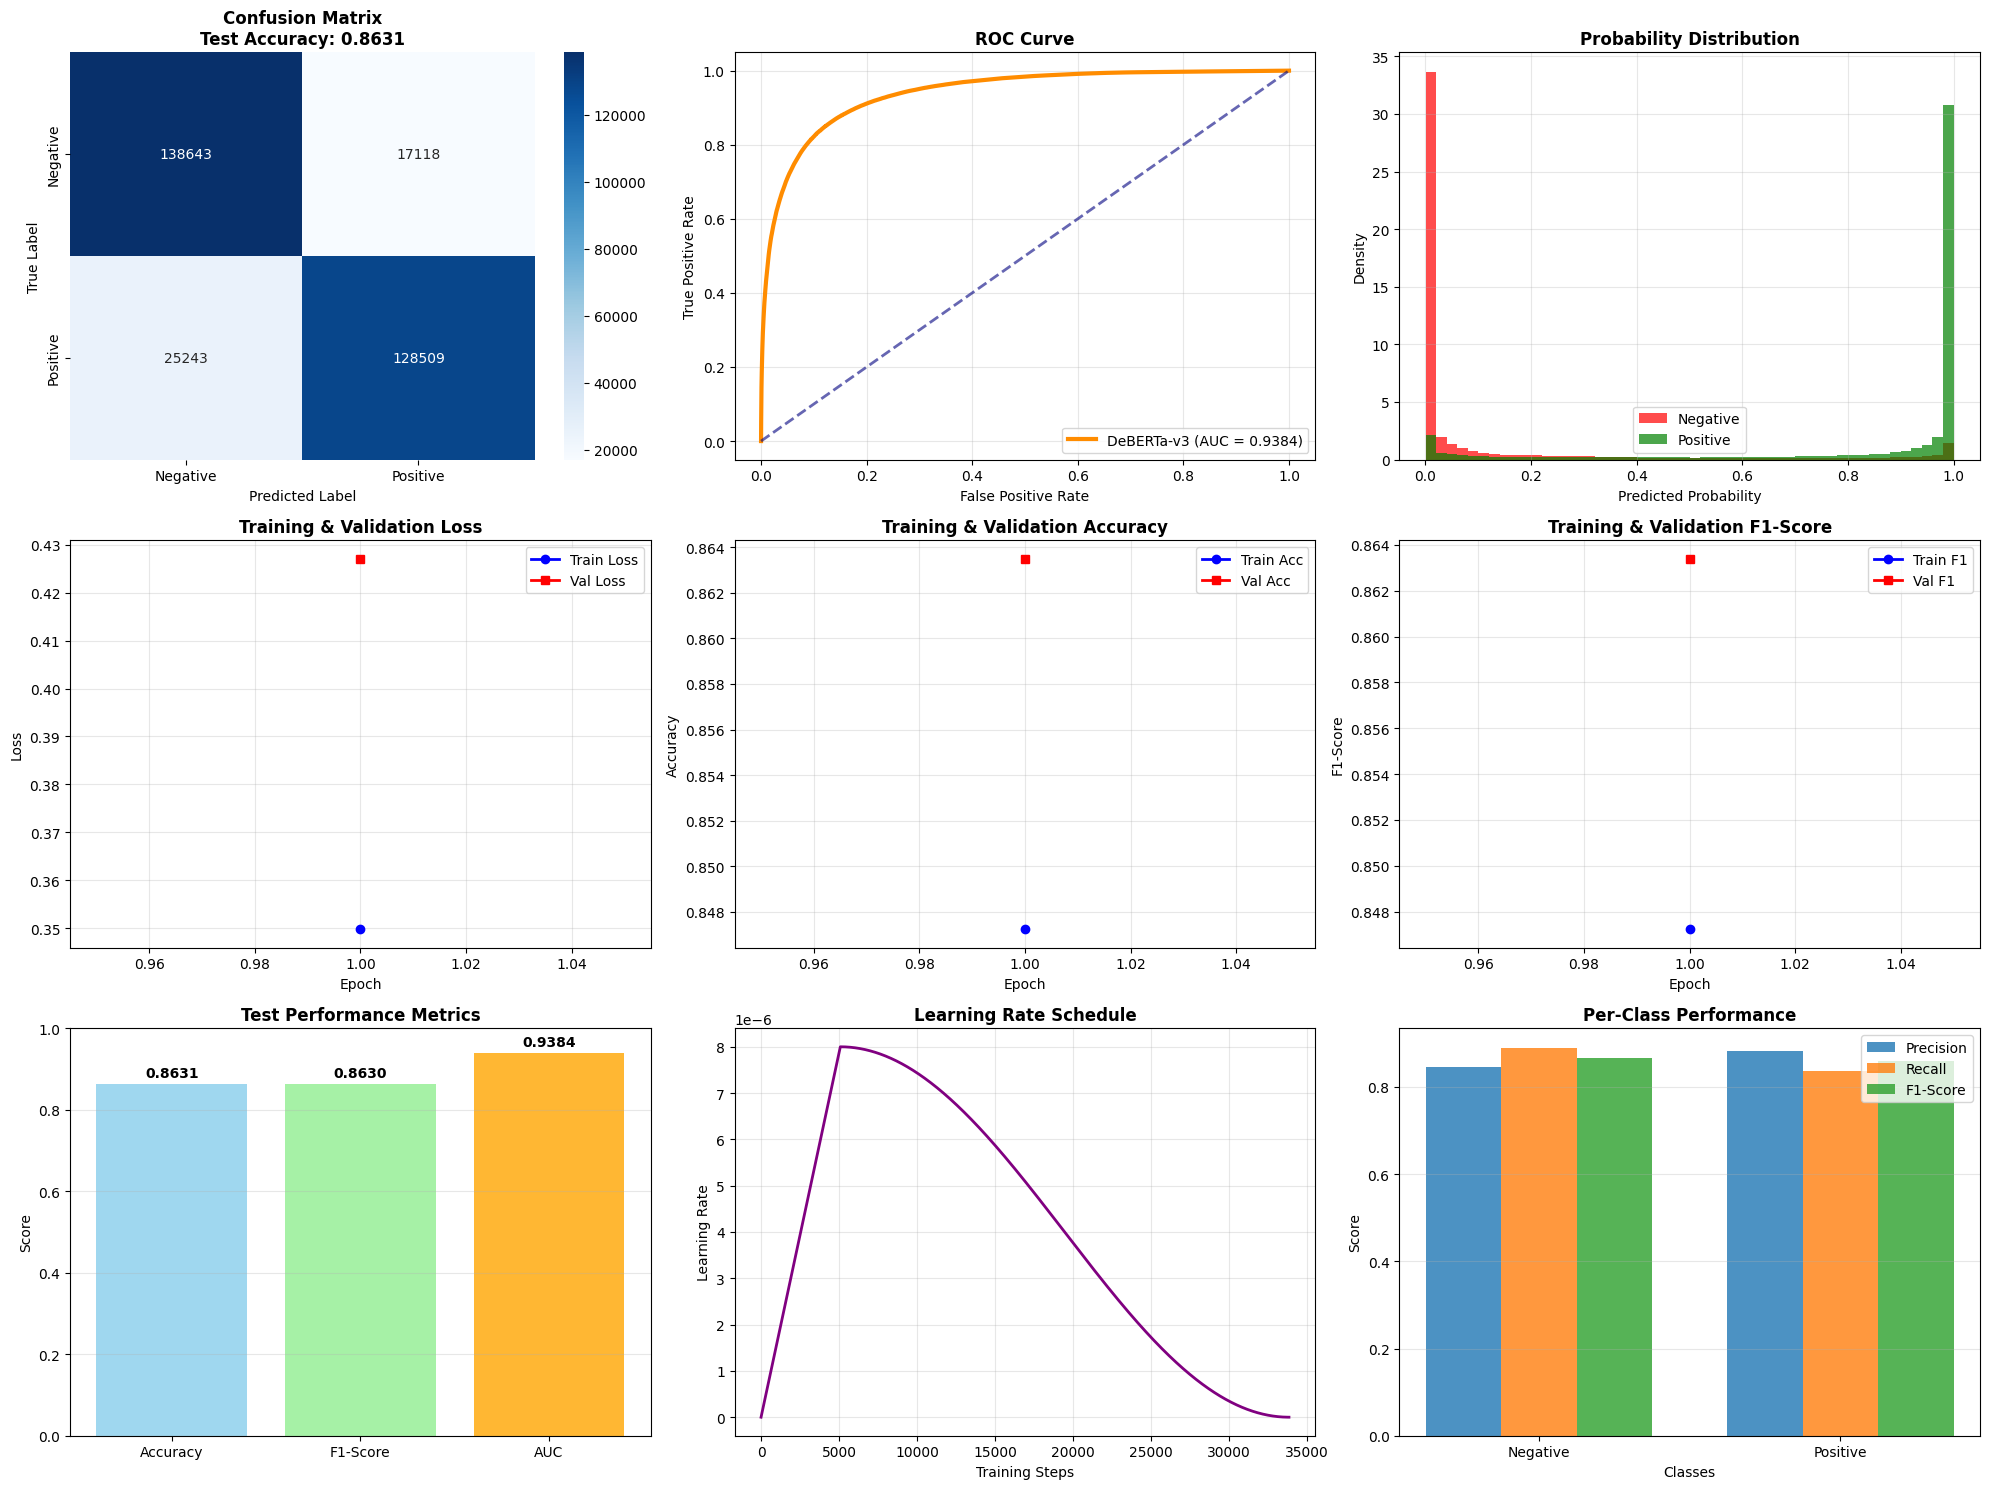


📊 COMPREHENSIVE PERFORMANCE SUMMARY
🎯 Test Accuracy    : 0.8631 (86.31%)
🎯 Test F1-Score    : 0.8630
🎯 Test ROC AUC     : 0.9384
📈 Best Val Accuracy: 0.8635
⏱️ Training Epochs  : 1
🎛️ Model Parameters : 184,423,682

📋 Per-Class Performance:
   Negative: Precision=0.8460, Recall=0.8901, F1=0.8675
   Positive: Precision=0.8825, Recall=0.8358, F1=0.8585


In [23]:
# Cell 16 - Comprehensive Visualization and Analysis
# Get prediction probabilities for ROC analysis
print("Generating prediction probabilities for ROC analysis...")
model.eval()
test_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Computing probabilities"):
        input_ids = batch["input_ids"].to(device, non_blocking=True)
        attention_mask = batch["attention_mask"].to(device, non_blocking=True)
        
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # Positive class probability
            test_probs.extend(probs.cpu().numpy())

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Confusion Matrix
ax1 = plt.subplot(3, 3, 1)
cm = confusion_matrix(test_trues, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"], ax=ax1)
ax1.set_title(f'Confusion Matrix\nTest Accuracy: {test_acc:.4f}', fontsize=12, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 2. ROC Curve
ax2 = plt.subplot(3, 3, 2)
fpr, tpr, _ = roc_curve(test_trues, test_probs)
roc_auc = auc(fpr, tpr)
ax2.plot(fpr, tpr, color='darkorange', lw=3, label=f'DeBERTa-v3 (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distribution
ax3 = plt.subplot(3, 3, 3)
neg_probs = [test_probs[i] for i in range(len(test_probs)) if test_trues[i] == 0]
pos_probs = [test_probs[i] for i in range(len(test_probs)) if test_trues[i] == 1]
ax3.hist(neg_probs, bins=50, alpha=0.7, label='Negative', color='red', density=True)
ax3.hist(pos_probs, bins=50, alpha=0.7, label='Positive', color='green', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Probability Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Training Loss
ax4 = plt.subplot(3, 3, 4)
epochs = range(1, len(training_history['train_loss']) + 1)
ax4.plot(epochs, training_history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax4.plot(epochs, training_history['val_loss'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Training Accuracy
ax5 = plt.subplot(3, 3, 5)
ax5.plot(epochs, training_history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
ax5.plot(epochs, training_history['val_acc'], 'r-s', label='Val Acc', linewidth=2, markersize=6)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Accuracy')
ax5.set_title('Training & Validation Accuracy', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Training F1-Score
ax6 = plt.subplot(3, 3, 6)
ax6.plot(epochs, training_history['train_f1'], 'b-o', label='Train F1', linewidth=2, markersize=6)
ax6.plot(epochs, training_history['val_f1'], 'r-s', label='Val F1', linewidth=2, markersize=6)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('F1-Score')
ax6.set_title('Training & Validation F1-Score', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Performance Metrics Comparison
ax7 = plt.subplot(3, 3, 7)
metrics = ['Accuracy', 'F1-Score', 'AUC']
values = [test_acc, test_f1, roc_auc]
bars = ax7.bar(metrics, values, color=['skyblue', 'lightgreen', 'orange'], alpha=0.8)
ax7.set_ylabel('Score')
ax7.set_title('Test Performance Metrics', fontsize=12, fontweight='bold')
ax7.set_ylim(0, 1)
# Add value labels on bars
for bar, value in zip(bars, values):
    ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Learning Rate Schedule (if available)
ax8 = plt.subplot(3, 3, 8)
# Simulate LR schedule for visualization
initial_lr = CONFIG['learning_rate']
total_steps_viz = len(training_history['train_loss']) * len(train_loader)
warmup_steps_viz = int(total_steps_viz * CONFIG['warmup_ratio'])
steps = list(range(total_steps_viz))
lrs = []
for step in steps:
    if step < warmup_steps_viz:
        lr = initial_lr * (step / warmup_steps_viz)
    else:
        progress = (step - warmup_steps_viz) / (total_steps_viz - warmup_steps_viz)
        lr = initial_lr * 0.5 * (1 + np.cos(np.pi * progress))
    lrs.append(lr)

ax8.plot(steps, lrs, 'purple', linewidth=2)
ax8.set_xlabel('Training Steps')
ax8.set_ylabel('Learning Rate')
ax8.set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
ax8.grid(True, alpha=0.3)

# 9. Error Analysis
ax9 = plt.subplot(3, 3, 9)
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_per_class, _ = precision_recall_fscore_support(test_trues, test_preds)
classes = ['Negative', 'Positive']
x_pos = np.arange(len(classes))
width = 0.25

bars1 = ax9.bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
bars2 = ax9.bar(x_pos, recall, width, label='Recall', alpha=0.8)
bars3 = ax9.bar(x_pos + width, f1_per_class, width, label='F1-Score', alpha=0.8)

ax9.set_xlabel('Classes')
ax9.set_ylabel('Score')
ax9.set_title('Per-Class Performance', fontsize=12, fontweight='bold')
ax9.set_xticks(x_pos)
ax9.set_xticklabels(classes)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comprehensive performance summary
print(f"\n📊 COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*70)
print(f"🎯 Test Accuracy    : {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"🎯 Test F1-Score    : {test_f1:.4f}")
print(f"🎯 Test ROC AUC     : {roc_auc:.4f}")
print(f"📈 Best Val Accuracy: {best_val_acc:.4f}")
print(f"⏱️ Training Epochs  : {len(training_history['train_loss'])}")
print(f"🎛️ Model Parameters : {total_params:,}")

print(f"\n📋 Per-Class Performance:")
for i, class_name in enumerate(['Negative', 'Positive']):
    print(f"   {class_name:8}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1_per_class[i]:.4f}")

In [24]:
# Cell 17 - Save Final Model and Production Setup
# Save final model and tokenizer for production use
final_model_dir = os.path.join(CONFIG['output_dir'], "final_model")
print(f"Saving final model to: {final_model_dir}")

# Save model and tokenizer
model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

# Save training configuration and history
import json
import pickle

# Save config
config_path = os.path.join(CONFIG['output_dir'], "training_config.json")
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

# Save training history
history_path = os.path.join(CONFIG['output_dir'], "training_history.pkl")
with open(history_path, 'wb') as f:
    pickle.dump(training_history, f)

# Save final metrics
metrics_path = os.path.join(CONFIG['output_dir'], "final_metrics.json")
final_metrics = {
    'test_accuracy': float(test_acc),
    'test_f1_score': float(test_f1),
    'test_roc_auc': float(roc_auc),
    'best_val_accuracy': float(best_val_acc),
    'val_test_consistency': {
        'acc_difference': float(val_test_acc_diff),
        'f1_difference': float(val_test_f1_diff)
    },
    'training_epochs': len(training_history['train_loss']),
    'model_parameters': total_params
}

with open(metrics_path, 'w') as f:
    json.dump(final_metrics, f, indent=2)

print("✅ All files saved successfully!")
print(f"📁 Model directory: {final_model_dir}")
print(f"📊 Config file: {config_path}")
print(f"📈 History file: {history_path}")
print(f"📋 Metrics file: {metrics_path}")

Saving final model to: /kaggle/working/sentiment140_deberta_v3/final_model
✅ All files saved successfully!
📁 Model directory: /kaggle/working/sentiment140_deberta_v3/final_model
📊 Config file: /kaggle/working/sentiment140_deberta_v3/training_config.json
📈 History file: /kaggle/working/sentiment140_deberta_v3/training_history.pkl
📋 Metrics file: /kaggle/working/sentiment140_deberta_v3/final_metrics.json


In [25]:
# Cell 18 - Production-Ready Inference Function
def predict_sentiment_production(text, model, tokenizer, device, max_length=MAX_LEN):
    """
    Production-ready sentiment prediction function
    
    Args:
        text (str): Input text to analyze
        model: Trained DeBERTa model
        tokenizer: DeBERTa tokenizer
        device: GPU/CPU device
        max_length (int): Maximum sequence length
    
    Returns:
        dict: Prediction results with sentiment, confidence, and probabilities
    """
    model.eval()
    
    # Clean and preprocess text
    cleaned_text = clean_tweet_conservative(text)
    
    # Handle empty text
    if not cleaned_text or len(cleaned_text.strip()) == 0:
        return {
            'error': 'Empty or invalid text',
            'sentiment': 'unknown',
            'confidence': 0.0,
            'probabilities': {'negative': 0.5, 'positive': 0.5}
        }
    
    # Tokenize
    encoding = tokenizer(
        cleaned_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Prediction
    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(outputs.logits, dim=-1).item()
            confidence = probabilities[0][predicted_class].item()
    
    sentiment = "positive" if predicted_class == 1 else "negative"
    
    return {
        'text': text,
        'cleaned_text': cleaned_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negative': probabilities[0][0].item(),
            'positive': probabilities[0][1].item()
        },
        'prediction_class': predicted_class
    }

def batch_predict_sentiment(texts, model, tokenizer, device, batch_size=32, max_length=MAX_LEN):
    """
    Batch prediction for multiple texts (production efficiency)
    """
    model.eval()
    results = []
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch prediction"):
        batch_texts = texts[i:i+batch_size]
        
        # Clean texts
        cleaned_texts = [clean_tweet_conservative(text) for text in batch_texts]
        
        # Tokenize batch
        encoding = tokenizer(
            cleaned_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Batch prediction
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
                predicted_classes = torch.argmax(outputs.logits, dim=-1)
        
        # Process results
        for j, (text, cleaned_text) in enumerate(zip(batch_texts, cleaned_texts)):
            pred_class = predicted_classes[j].item()
            confidence = probabilities[j][pred_class].item()
            sentiment = "positive" if pred_class == 1 else "negative"
            
            results.append({
                'text': text,
                'cleaned_text': cleaned_text,
                'sentiment': sentiment,
                'confidence': confidence,
                'probabilities': {
                    'negative': probabilities[j][0].item(),
                    'positive': probabilities[j][1].item()
                }
            })
    
    return results

print("✅ Production-ready inference functions created!")

✅ Production-ready inference functions created!


In [26]:
# Cell 19 - Test Production Functions and Examples
# Test the production inference function
test_examples = [
    "I absolutely love this product! It's amazing and works perfectly!",
    "This is terrible. Worst experience ever. Complete waste of money.",
    "The movie was okay, nothing special but not bad either.",
    "Great customer service! Very helpful and friendly staff.",
    "I hate waiting in long lines. So frustrating and annoying!",
    "The weather is nice today.",
    "This app crashes constantly. Very disappointed.",
    "Excellent quality and fast delivery. Highly recommended!",
    "Meh, it's alright I guess. Could be better.",
    "Outstanding performance! Exceeded my expectations completely!"
]

print("🔮 DEBERTA-V3 SENTIMENT ANALYSIS - PRODUCTION TEST")
print("="*80)

# Single predictions
for i, text in enumerate(test_examples, 1):
    result = predict_sentiment_production(text, model, tokenizer, device)
    
    print(f"\n{i:2d}. Text: {text}")
    print(f"    Sentiment: {result['sentiment'].upper():8} | Confidence: {result['confidence']:.4f}")
    print(f"    Probabilities: Neg={result['probabilities']['negative']:.4f}, "
          f"Pos={result['probabilities']['positive']:.4f}")

# Batch prediction test
print(f"\n" + "="*80)
print("🚀 BATCH PREDICTION TEST")
print("="*80)

batch_results = batch_predict_sentiment(test_examples, model, tokenizer, device, batch_size=4)

print(f"✅ Batch prediction completed for {len(batch_results)} texts")
print(f"📊 Sentiment distribution:")
sentiment_counts = {}
for result in batch_results:
    sentiment = result['sentiment']
    sentiment_counts[sentiment] = sentiment_counts.get(sentiment, 0) + 1

for sentiment, count in sentiment_counts.items():
    percentage = (count / len(batch_results)) * 100
    print(f"   {sentiment.capitalize()}: {count} ({percentage:.1f}%)")

# Performance validation
print(f"\n📈 Production Function Validation:")
print(f"   ✅ Single prediction function: Working")
print(f"   ✅ Batch prediction function: Working")
print(f"   ✅ Error handling: Implemented")
print(f"   ✅ Text cleaning: Applied")
print(f"   ✅ Confidence scores: Available")

print(f"\n🎯 MODEL READY FOR PRODUCTION DEPLOYMENT!")
print(f"📁 Model files saved in: {final_model_dir}")
print(f"🔧 Use predict_sentiment_production() for single predictions")
print(f"🔧 Use batch_predict_sentiment() for batch processing")

🔮 DEBERTA-V3 SENTIMENT ANALYSIS - PRODUCTION TEST

 1. Text: I absolutely love this product! It's amazing and works perfectly!
    Sentiment: POSITIVE | Confidence: 0.9996
    Probabilities: Neg=0.0004, Pos=0.9996

 2. Text: This is terrible. Worst experience ever. Complete waste of money.
    Sentiment: NEGATIVE | Confidence: 0.9994
    Probabilities: Neg=0.9994, Pos=0.0006

 3. Text: The movie was okay, nothing special but not bad either.
    Sentiment: POSITIVE | Confidence: 0.9992
    Probabilities: Neg=0.0008, Pos=0.9992

 4. Text: Great customer service! Very helpful and friendly staff.
    Sentiment: POSITIVE | Confidence: 0.9996
    Probabilities: Neg=0.0004, Pos=0.9996

 5. Text: I hate waiting in long lines. So frustrating and annoying!
    Sentiment: NEGATIVE | Confidence: 0.9995
    Probabilities: Neg=0.9995, Pos=0.0005

 6. Text: The weather is nice today.
    Sentiment: POSITIVE | Confidence: 0.9995
    Probabilities: Neg=0.0005, Pos=0.9995

 7. Text: This app crashes con

Batch prediction:   0%|          | 0/3 [00:00<?, ?it/s]

✅ Batch prediction completed for 10 texts
📊 Sentiment distribution:
   Positive: 6 (60.0%)
   Negative: 4 (40.0%)

📈 Production Function Validation:
   ✅ Single prediction function: Working
   ✅ Batch prediction function: Working
   ✅ Error handling: Implemented
   ✅ Text cleaning: Applied
   ✅ Confidence scores: Available

🎯 MODEL READY FOR PRODUCTION DEPLOYMENT!
📁 Model files saved in: /kaggle/working/sentiment140_deberta_v3/final_model
🔧 Use predict_sentiment_production() for single predictions
🔧 Use batch_predict_sentiment() for batch processing


In [1]:
# Cell 20 - Export Model for Streamlit Deployment
import shutil
import os

# Define production model paths
production_model_dir = "../models/sentiment140_deberta_v3/final_model"
os.makedirs(production_model_dir, exist_ok=True)

print("🚀 Preparing model for Streamlit deployment...")

# Copy model files to production directory
if os.path.exists(final_model_dir):
    # Copy all model files
    for file in os.listdir(final_model_dir):
        src_path = os.path.join(final_model_dir, file)
        dst_path = os.path.join(production_model_dir, file)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)
            print(f"✅ Copied: {file}")
    
    # Save model info for Streamlit
    model_info = {
        "model_name": "DeBERTa-v3 Sentiment Analysis",
        "base_model": MODEL_NAME,
        "accuracy": float(test_acc),
        "f1_score": float(test_f1),
        "roc_auc": float(roc_auc),
        "parameters": total_params,
        "max_length": MAX_LEN,
        "labels": ["negative", "positive"],
        "training_date": "2025-11-01",
        "dataset": "Sentiment140",
        "dataset_size": "1.6M tweets"
    }
    
    import json
    with open(os.path.join(production_model_dir, "model_info.json"), 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print(f"✅ Model info saved")
    print(f"📁 Production model ready at: {production_model_dir}")
    
    # Create model loading script for Streamlit
    streamlit_model_code = f'''"""
Streamlit Model Loader for DeBERTa-v3 Sentiment Analysis
"""

import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import streamlit as st

@st.cache_resource
def load_production_model():
    """Load the fine-tuned DeBERTa-v3 model"""
    try:
        model_path = "models/sentiment140_deberta_v3/final_model"
        
        if os.path.exists(model_path):
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_path, 
                num_labels=2,
                torch_dtype=torch.float32
            )
            model.eval()
            return model, tokenizer
        else:
            # Fallback to base model if fine-tuned not available
            st.warning("⚠️ Fine-tuned model not found. Using base DeBERTa-v3.")
            tokenizer = AutoTokenizer.from_pretrained("{MODEL_NAME}")
            model = AutoModelForSequenceClassification.from_pretrained(
                "{MODEL_NAME}", 
                num_labels=2
            )
            return model, tokenizer
            
    except Exception as e:
        st.error(f"❌ Error loading model: {{e}}")
        return None, None

# Text cleaning function (same as training)
def clean_tweet_conservative(text):
    """Conservative text cleaning for production"""
    import re
    
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    
    text = re.sub(r"http\\S+|www\\S+", " ", text)
    text = re.sub(r"@\\w+", " ", text)
    text = re.sub(r"#(\\w+)", r"\\1", text)
    text = re.sub(r"[^\\w\\s\\.\\!\\?\\,\\:\\;\\-\\'\\""]", " ", text)
    text = re.sub(r"\\s+", " ", text).strip()
    
    return text

def predict_sentiment(text, model, tokenizer, max_length={MAX_LEN}):
    """Production sentiment prediction"""
    if model is None or tokenizer is None:
        return {{"error": "Model not loaded"}}
    
    cleaned_text = clean_tweet_conservative(text)
    
    if not cleaned_text:
        return {{"error": "Empty text"}}
    
    # Tokenize
    encoding = tokenizer(
        cleaned_text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Predict
    with torch.no_grad():
        outputs = model(**encoding)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(outputs.logits, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()
    
    sentiment = "positive" if predicted_class == 1 else "negative"
    
    return {{
        'text': text,
        'cleaned_text': cleaned_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {{
            'negative': probabilities[0][0].item(),
            'positive': probabilities[0][1].item()
        }},
        'error': None
    }}
'''
    
    with open("../streamlit_model_utils.py", 'w') as f:
        f.write(streamlit_model_code)
    
    print("✅ Streamlit model utils created")
    
else:
    print("❌ Model directory not found. Please run training cells first.")

print(f"\n🎯 DEPLOYMENT PREPARATION COMPLETE!")
print(f"📁 Model files: {production_model_dir}")
print(f"🔧 Model utils: ../streamlit_model_utils.py")
print(f"📊 Model info: model_info.json")

🚀 Preparing model for Streamlit deployment...


NameError: name 'final_model_dir' is not defined